In [1]:
import findspark
# findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
findspark.init('../spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('modelling').getOrCreate()

from pyspark.ml import Pipeline
from pyspark.ml.classification import (RandomForestClassifier, GBTClassifier, DecisionTreeClassifier,\
                                       LogisticRegression, MultilayerPerceptronClassifier)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


from pyspark.sql.functions import col, when
from pyspark.ml.feature import VectorAssembler

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/23 13:44:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
df = spark.read.csv("data.csv", header=True)
for c in df.columns:
    df = df.withColumn(c,col(c).cast('double'))
df.printSchema()

root
 |-- Diabetes: double (nullable = true)
 |-- HighBP: double (nullable = true)
 |-- HighChol: double (nullable = true)
 |-- CholCheck: double (nullable = true)
 |-- Smoker: double (nullable = true)
 |-- Stroke: double (nullable = true)
 |-- HeartDiseaseorAttack: double (nullable = true)
 |-- PhysActivity: double (nullable = true)
 |-- Fruits: double (nullable = true)
 |-- Veggies: double (nullable = true)
 |-- AnyHealthcare: double (nullable = true)
 |-- NoDocbcCost: double (nullable = true)
 |-- DiffWalk: double (nullable = true)
 |-- Sex: double (nullable = true)
 |-- BMI: double (nullable = true)



In [3]:
from pyspark.ml.feature import VectorAssembler
features_names = ['HighBP', 'HighChol', 'CholCheck', 'Smoker','Stroke', 'HeartDiseaseorAttack', \
                  'PhysActivity', 'Fruits','Veggies', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', \
                 'Sex', 'BMI']
assembler = VectorAssembler(inputCols=features_names, outputCol="features")

# assembler = VectorAssembler(inputCols=df.columns, outputCol="features")
df = assembler.transform(df)

In [4]:
df.printSchema()

root
 |-- Diabetes: double (nullable = true)
 |-- HighBP: double (nullable = true)
 |-- HighChol: double (nullable = true)
 |-- CholCheck: double (nullable = true)
 |-- Smoker: double (nullable = true)
 |-- Stroke: double (nullable = true)
 |-- HeartDiseaseorAttack: double (nullable = true)
 |-- PhysActivity: double (nullable = true)
 |-- Fruits: double (nullable = true)
 |-- Veggies: double (nullable = true)
 |-- AnyHealthcare: double (nullable = true)
 |-- NoDocbcCost: double (nullable = true)
 |-- DiffWalk: double (nullable = true)
 |-- Sex: double (nullable = true)
 |-- BMI: double (nullable = true)
 |-- features: vector (nullable = true)



# Train Test split

In [5]:
train_data,test_data = df.select(['Diabetes', 'features']).randomSplit([0.7,0.3])

In [6]:
print("train data set length:", train_data.count())
print("test data set length:", test_data.count())

24/05/23 13:44:39 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


train data set length: 48965


test data set length: 21317


In [7]:
train_data.show()

+--------+--------------------+
|Diabetes|            features|
+--------+--------------------+
|     0.0|(14,[0,1,2,3,4,5,...|
|     0.0|(14,[0,1,2,3,4,6,...|
|     0.0|(14,[0,1,2,3,4,6,...|
|     0.0|(14,[0,1,2,3,4,7,...|
|     0.0|(14,[0,1,2,3,4,8,...|
|     0.0|(14,[0,1,2,3,4,8,...|
|     0.0|(14,[0,1,2,3,4,8,...|
|     0.0|(14,[0,1,2,3,4,9,...|
|     0.0|(14,[0,1,2,3,4,10...|
|     0.0|(14,[0,1,2,3,5,6,...|
|     0.0|(14,[0,1,2,3,5,6,...|
|     0.0|(14,[0,1,2,3,5,6,...|
|     0.0|(14,[0,1,2,3,5,6,...|
|     0.0|(14,[0,1,2,3,5,6,...|
|     0.0|(14,[0,1,2,3,5,6,...|
|     0.0|(14,[0,1,2,3,5,8,...|
|     0.0|(14,[0,1,2,3,5,8,...|
|     0.0|(14,[0,1,2,3,5,8,...|
|     0.0|(14,[0,1,2,3,5,8,...|
|     0.0|(14,[0,1,2,3,5,9,...|
+--------+--------------------+
only showing top 20 rows



In [8]:
from pyspark.sql.functions import col, explode, array, lit
major_df = df.filter(col("Diabetes") == 0)
minor_df = df.filter(col("Diabetes") == 1)
ratio = major_df.count()/minor_df.count()
print("ratio: {}".format(ratio))

ratio: 1.03344617076064


In [9]:
train_data.printSchema()

root
 |-- Diabetes: double (nullable = true)
 |-- features: vector (nullable = true)



# Machine learning model selection

In [10]:
from pyspark.mllib.classification import SVMWithSGD, SVMModel
from pyspark.ml.classification import LogisticRegression

In [11]:
dtc = DecisionTreeClassifier(labelCol='Diabetes',featuresCol='features')
rfc = RandomForestClassifier(labelCol='Diabetes',featuresCol='features',numTrees=5)
lr = LogisticRegression(labelCol='Diabetes',featuresCol='features')

In [12]:
dtc_model = dtc.fit(train_data)
rfc_model = rfc.fit(train_data)
lr_model = lr.fit(train_data)

24/05/23 13:45:00 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/05/23 13:45:00 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


In [13]:
dtc_predictions = dtc_model.transform(test_data)
rfc_predictions = rfc_model.transform(test_data)
lr_predictions = lr_model.transform(test_data)

In [14]:
# Random Forest Feature Importances
rfc_importances = rfc_model.featureImportances
print("Random Forest Feature Importances:")
for i, (col, importance) in enumerate(zip(features_names, rfc_importances)):
    print(f"{col}: {importance}")

Random Forest Feature Importances:
HighBP: 0.5699264320714743
HighChol: 0.05921483368082908
CholCheck: 0.004804106880170869
Smoker: 0.0019883510493771237
Stroke: 0.0036444917772804745
HeartDiseaseorAttack: 0.04192637058945018
PhysActivity: 0.0021266537961235066
Fruits: 0.0
Veggies: 0.0018252073102945612
AnyHealthcare: 5.383539426653853e-06
NoDocbcCost: 0.00046673900488118457
DiffWalk: 0.15988377871308065
Sex: 0.0004127817329935296
BMI: 0.1537748698546175


In [15]:
# Decision Tree Classification Feature Importances
dtc_importances = dtc_model.featureImportances
print("Decision Tree Classification Feature Importances:")
for i, (col, importance) in enumerate(zip(features_names, dtc_importances)):
    print(f"{col}: {importance}")

Decision Tree Classification Feature Importances:
HighBP: 0.630017154083544
HighChol: 0.08199306257205084
CholCheck: 0.0
Smoker: 0.0
Stroke: 0.0
HeartDiseaseorAttack: 0.02675836300378576
PhysActivity: 0.0
Fruits: 0.0
Veggies: 0.0
AnyHealthcare: 0.0
NoDocbcCost: 0.0
DiffWalk: 0.11523344386707253
Sex: 0.0
BMI: 0.14599797647354687


In [16]:
lr_predictions.show()

+--------+--------------------+--------------------+--------------------+----------+
|Diabetes|            features|       rawPrediction|         probability|prediction|
+--------+--------------------+--------------------+--------------------+----------+
|     0.0|(14,[0,1,2,3,4,6,...|[-1.0657252356453...|[0.25621687580682...|       1.0|
|     0.0|(14,[0,1,2,3,4,8,...|[-0.6530588202213...|[0.34230057060523...|       1.0|
|     0.0|(14,[0,1,2,3,4,8,...|[-0.7907574378218...|[0.31200605597201...|       1.0|
|     0.0|(14,[0,1,2,3,4,9,...|[-1.4005867824927...|[0.19772301443198...|       1.0|
|     0.0|(14,[0,1,2,3,4,9,...|[-1.6759840176938...|[0.15762798374611...|       1.0|
|     0.0|(14,[0,1,2,3,4,9,...|[-1.8825319440946...|[0.13209831982244...|       1.0|
|     0.0|(14,[0,1,2,3,5,6,...|[-1.0228322061369...|[0.26447608837314...|       1.0|
|     0.0|(14,[0,1,2,3,5,8,...|[-0.7351654500178...|[0.32406223007091...|       1.0|
|     0.0|(14,[0,1,2,3,5,8,...|[-0.9417133764186...|[0.2805543784

In [17]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [18]:
result_eval = BinaryClassificationEvaluator(labelCol = 'Diabetes')

In [19]:
dtc_acc = result_eval.evaluate(dtc_predictions)
rfc_acc = result_eval.evaluate(rfc_predictions)
lr_acc = result_eval.evaluate(lr_predictions)

In [20]:
print("Decision Tree Classifier:", dtc_acc)
print("Random Forecast Classifier:",rfc_acc)
print("Logistic Regression Classifier:",lr_acc)

Decision Tree Classifier: 0.6887057274533843
Random Forecast Classifier: 0.7843262268413596
Logistic Regression Classifier: 0.7913172293243625


In [21]:
# lr_summay = lr_model.summary
# lr_summay.predictions.printSchema()
# lr_summay.predictions.show()

In [22]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
acc_evaluator = MulticlassClassificationEvaluator(labelCol="Diabetes", predictionCol="prediction", metricName="accuracy")

In [23]:
dtc_acc = acc_evaluator.evaluate(dtc_predictions)
rfc_acc = acc_evaluator.evaluate(rfc_predictions)
lr_acc = acc_evaluator.evaluate(lr_predictions)

In [24]:
print('-'*40)
print('A single decision tree has an accuracy of: {0:2.2f}%'.format(dtc_acc*100))
print('-'*40)
print('A random forest ensemble has an accuracy of: {0:2.2f}%'.format(rfc_acc*100))
print('-'*40)
print('A logistic regression model has an accuracy of: {0:2.2f}%'.format(lr_acc*100))
print('-'*40)

----------------------------------------
A single decision tree has an accuracy of: 71.30%
----------------------------------------
A random forest ensemble has an accuracy of: 71.15%
----------------------------------------
A logistic regression model has an accuracy of: 71.80%
----------------------------------------


# Modelling

In [25]:
# 80-20 train-test split
train_data,test_data = df.select(['Diabetes', 'features']).randomSplit([0.8,0.2])

In [26]:
# Fit random forest model
rfc = RandomForestClassifier(labelCol='Diabetes',featuresCol='features',numTrees=5)
rfc_model = rfc.fit(train_data)
rfc_predictions = rfc_model.transform(test_data)

In [27]:
# initialize evaluator
result_eval = BinaryClassificationEvaluator(labelCol = 'Diabetes')

In [28]:
# Evaluate accuracy
rfc_acc = result_eval.evaluate(rfc_predictions)
print("Random Forecast Classifier:",rfc_acc)

Random Forecast Classifier: 0.7894355763244622


In [29]:
# Random Forest Feature Importances
rfc_importances = rfc_model.featureImportances
print("Random Forest Feature Importances:")
for i, (col, importance) in enumerate(zip(features_names, rfc_importances)):
    print(f"{col}: {importance}")

Random Forest Feature Importances:
HighBP: 0.5609041785173468
HighChol: 0.05004734011918041
CholCheck: 0.007217472578232265
Smoker: 0.000992455904558927
Stroke: 0.0014744096278643491
HeartDiseaseorAttack: 0.04035165771955702
PhysActivity: 0.0007347152755142647
Fruits: 0.00023344846097538154
Veggies: 0.002000461235585515
AnyHealthcare: 3.307130110840067e-05
NoDocbcCost: 0.0
DiffWalk: 0.1699735772821825
Sex: 0.002246188098295104
BMI: 0.16379102387959896


# Visualization 

In [36]:
# load packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col

# read data as pandas dataset for visualization purpose only
df_v = spark.read.csv("data.csv", header=True)
for c in df_v.columns:
    df_v = df_v.withColumn(c,col(c).cast('double'))
df_v = df_v.toPandas()


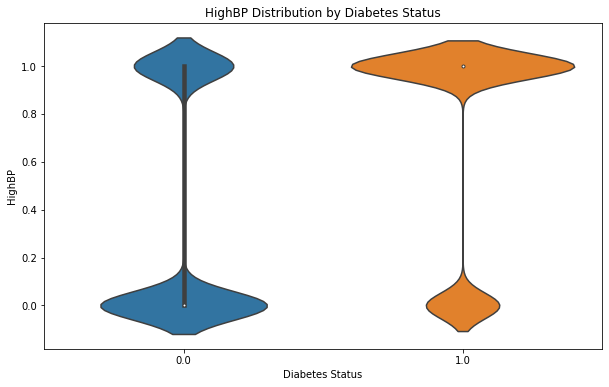

In [38]:
# plot most importance feature and target
plt.figure(figsize=(10, 6))
sns.violinplot(x='Diabetes', y='HighBP', data=df_v)
plt.title('HighBP Distribution by Diabetes Status')
plt.xlabel('Diabetes Status')
plt.ylabel('HighBP')
plt.show()

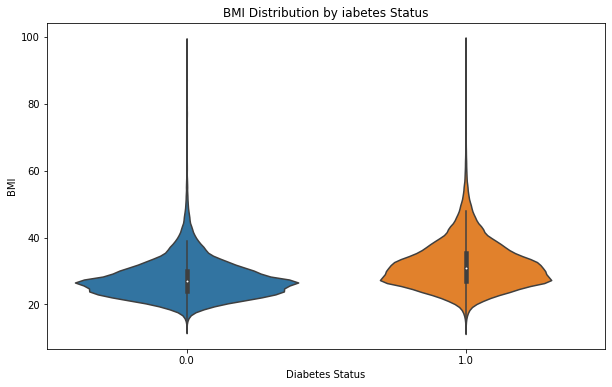

In [40]:
# violin plot for diabetes and bmi
plt.figure(figsize=(10, 6))
sns.violinplot(x='Diabetes', y='BMI', data=df_v)
plt.title('BMI Distribution by iabetes Status')
plt.xlabel('Diabetes Status')
plt.ylabel('BMI')
plt.show()

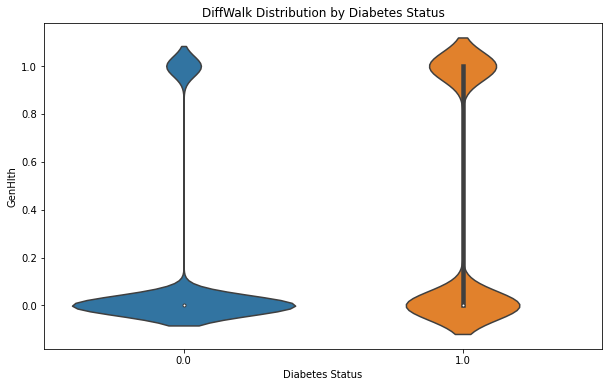

In [42]:
# violin plot for diabetes and GenHlth
plt.figure(figsize=(10, 6))
sns.violinplot(x='Diabetes', y='DiffWalk', data=df_v)
plt.title('DiffWalk Distribution by Diabetes Status')
plt.xlabel('Diabetes Status')
plt.ylabel('GenHlth')
plt.show()